# Tomographic Binning as Clustering

The inspiration for my somewhat unique (but evidently viable) submission for the tomographic challenge was firstly the visual inspection of the PCA-reduced dataset that I've presented a few times in the past, and secondly the fact that I wanted my method to be fast. When plotting the "optimal" binnings generated in training the random forest, there appeared to be a rough correlation between the two or three dimension space and the bin assignment (and by extension, redshift). 

This visual correlation made me wonder if there was a way we could cluster the points and generate a similar binning. In this scheme, each observation is assigned to a bin by finding which "prototype" observation (or henceforth, centroid) is closest to it. To solve this problem I will first present a super abbreviated explanation of the math, and then go into the code.

This method has a few tradeoffs over others. Compared to things like neural networks, it takes approximately the same amount of time to train. It is much longer training than a random forest. It is, however, the fastest possible *classification* method that I can think of, since classification is entirely done by calculating distance between points and centroids, a vector length problem that has been optimized to death in computer science.

Interestingly it performs rather well on FOM optimization, when hyperparameters are intelligently chosen. It seems to not like SNR optimization that much. On the former it can exceed the performance of a Random Forest by nearly double in some cases. In the latter it always falls short. 

In [1]:
# Plotting
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_palette("bright") # I don't like the default.

# For looping but only printing each loop
from IPython.display import clear_output 

# The tomo challege package and metrics
import sys
sys.path.insert(0, '../')
import tomo_challenge as tc
from tomo_challenge.jax_metrics import compute_snr_score, compute_fom

# Built in library
import time

# Jax imports, and turn on 64 bit
from jax import grad
import jax
import jax.numpy as jnp
from jax.core import UnexpectedTracerError
from jax import config
config.update("jax_enable_x64", True)

# Setting seeds for any random number generations
np.random.seed(1985)
gen = np.random.RandomState(seed=1985)

Found classifier PCACluster
Found classifier IBandOnly
Found classifier RandomForest
Found classifier Random


In [2]:
d_loc = "../data"
x_train = pd.DataFrame.from_dict(tc.load_data(f"{d_loc}/training.hdf5", "griz", colors=True, errors=True))
z_train = tc.load_redshift(f"{d_loc}/training.hdf5")

../tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


## PCA

My first step here is to reduce the data from four dimensions (three colors, and one magnitude) down to two or three. I experimented this method on both two and three dimensional forms of the data, andfrankly it's much more powerful in three dimensions. In four the method does not gain any additional information from three except for taking longer to calculate distances (as you have a whole additional dimension to deal with!)

The usual way to find principal component axes is to take the eigenvectors of the covariance matrix of the data. In order to properly find the covariance, we must subtract the mean of the data from the dataset to make the mean 0. In PCA with weights, we instead subtract the weighted mean. 

I use the err in r-band magnitudes.

In [3]:
color_data = x_train[["r", "gr", "ri", "rz"]].to_numpy()
errs = x_train[["r_err"]].to_numpy()

# This is necessary because using the inverse variance is standard for weights
# but the inverse of ~0 is near infinite. This
# short code strip sets variance lower than 0.01 to the maximum (in our case, 1)
# and the rest to 1/variance. Then normalizes the rest to [0,1]
# For fun you can change this threshold to see what happens.
# I do this this way because none of the variance is exactly 0. Instead everything is
# "really close" to 0 so instead of getting a nan where we have 1/0 we get really big numbers
# and then only 1 or 2 observations dominates the PCA. In this scheme all errs <= 0.01
# are equally important in calculating PCA, and the rest depend on their errs. 
err_thresh = 0.01
err_cond = errs >= err_thresh
weights = np.where(errs < err_thresh, 1, 1/errs**2)
weights[err_cond] = weights[err_cond] / np.max(weights[err_cond])

In [4]:
# Make the mean zero then find the covariance matrix
# divde by len-1 because sample and not population covariance
# First line is unweighted mean, second is the weighted average.
# color_shifted = color_data - np.mean(color_data, axis=0)
color_shifted = color_data - np.average(color_data[:,0].reshape(-1, 1), weights=weights)
cov = color_shifted.T @ color_shifted / (color_shifted.shape[0] - 1)

# Find the eigen values and eigen vectors of the covariance matrix
# The eigen vectors are vertical!
# Eigen vectors are principal components of dataset
eigen_variance, eigen_matrix = np.linalg.eig(cov)

# Sorting so we make sure that the vectors are in order of importance
eigen_matrix = eigen_matrix[np.argsort(-eigen_variance)]
eigen_variance = eigen_variance[np.argsort(-eigen_variance)]

24.139006057450977
22.371130249024198


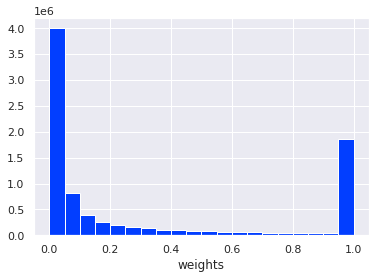

In [5]:
# Just checking to make sure this looks reasonable ish. 
plt.hist(weights, bins=20)
plt.xlabel("weights")

print(np.mean(color_data[:,0]))
print(np.average(color_data[:,0].reshape(-1, 1), weights=weights))

I use a mixture of PCA and PCA with per observation weights (wPCA). My implementation of the PCA algorithm is based on math outlined by *Stephen Bailey* in **[Principal Component Analysis with Noisy and/or Missing Data](https://doi.org/10.1086%2F668105)**. I subtract the weighted mean of the data instead of the regular mean, as the first step in wPCA. However I use simple unweighted PCA to calculate axes, largely because the difference between the wPCA and PCA axes after this point are minimal, but the former takes longer to compute due to additional vector multiplication. But try it for yourself! In the cell below the one defining `find_eigenvector`, change `None` to the weights I used to calculate the weighted average, `weights`. Then replot the data and you'll see the structure is the same, just shifted! It's quicker even still to use numpy's calculation of the eigen vectors (above, the eigen vectors of the covariance), but the whole reason I left my iterative implementation here is to show how the 2d and 3d space representations with and without weights are pretty similar when the weighted average is subracted. 

In [6]:
def find_eigenvector(data, weights=None):
    # Start with position 1985 as a "random" start point. 
    # 1985 is the year my favourite movie came out. No other reason than that. 
    phi = data[1985].reshape(1, -1)
    
    if weights is None:
        weights = np.ones_like(phi)

    thresh = 1e-6
    cond = False
    i = 0
    while not cond:
        # Find the coefficients that match the eigen vector to the data vector
        coeffs = data @ phi.T

        # Project the data along phi axis by multiplying the data by the coefficient
        proj = data * coeffs * weights

        # Sum all the projected ones to find the new eigenvector and then divide by the
        # length of the vector to reduce it to unit vector length.
        phi_new = np.sum(proj, axis=0)
        phi_new = phi_new / np.linalg.norm(phi_new)

        # If all of the dimensions changes by less than thresh then the
        # condition is set to true and the loop breaks
        cond = np.all((phi_new - phi) < thresh)

        phi = phi_new.reshape(1, -1)
        i += 1
    print("Iterations:", i + 1)
    return phi

In [7]:
eigs = []
num_eigs = 4
eigs = np.zeros((color_shifted.shape[1], num_eigs))
temp_data = np.copy(color_shifted)
for i in range(num_eigs):
    v = find_eigenvector(temp_data, None)
    eigs[:,i] = (v)
    
    # Subtract the projections of the first eigen vector to start finding the next one.
    coeffs = temp_data @ v.T
    temp_data = temp_data - coeffs * v

print(eigs)
# Closeness assertions for testing purposes.
# assert np.allclose(eigs[:,0], eigen_matrix[:,0]) or np.allclose(-eigs[:,0], eigen_matrix[:,0], atol=1e-3)
# assert np.allclose(eigs[:,1], eigen_matrix[:,1]) or np.allclose(-eigs[:,1], eigen_matrix[:,1], atol=1e-3)
# assert np.allclose(eigs[:,2], eigen_matrix[:,2]) or np.allclose(-eigs[:,2], eigen_matrix[:,2], atol=1e-3)
# assert np.allclose(eigs[:,3], eigen_matrix[:,3]) or np.allclose(-eigs[:,3], eigen_matrix[:,3], atol=1e-3)

Iterations: 4
Iterations: 11
Iterations: 8
Iterations: 3
[[ 0.0471107   0.99857377 -0.02047592  0.01455131]
 [-0.57526083  0.01125107 -0.81585551 -0.05769038]
 [-0.58179452  0.02417952  0.35897862  0.72942775]
 [-0.57303638  0.04625134  0.45287402 -0.68146551]]


[0.99790122 0.99964486 0.9999619  1.        ]


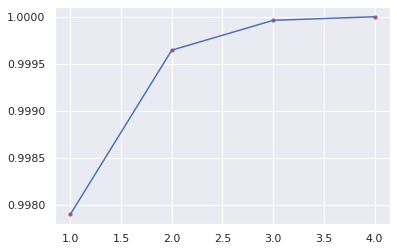

In [8]:
# Plots the amount of variance in the data explained by the number
# of principal components chosen.
x = np.arange(0, len(eigen_variance)) + 1
y = np.cumsum(eigen_variance) / np.sum(eigen_variance)

plt.plot(x, y, c="b")
plt.scatter(x, y, s=10, c="r")
print(y)

In [9]:
# The selection of principal axis vectors that will reduce dimensionality
reducer = eigs[:, 0:3]
data_reduced = color_data @ reducer

# I took this cut from the random forest example.
# I cut after doing the PCA in case the cut changes the
# principal axes and I want to avoid that.
cut = np.random.uniform(0, 1, data_reduced.shape[0]) < 0.05
data_cut =  data_reduced[cut]
z_cut = z_train[cut]

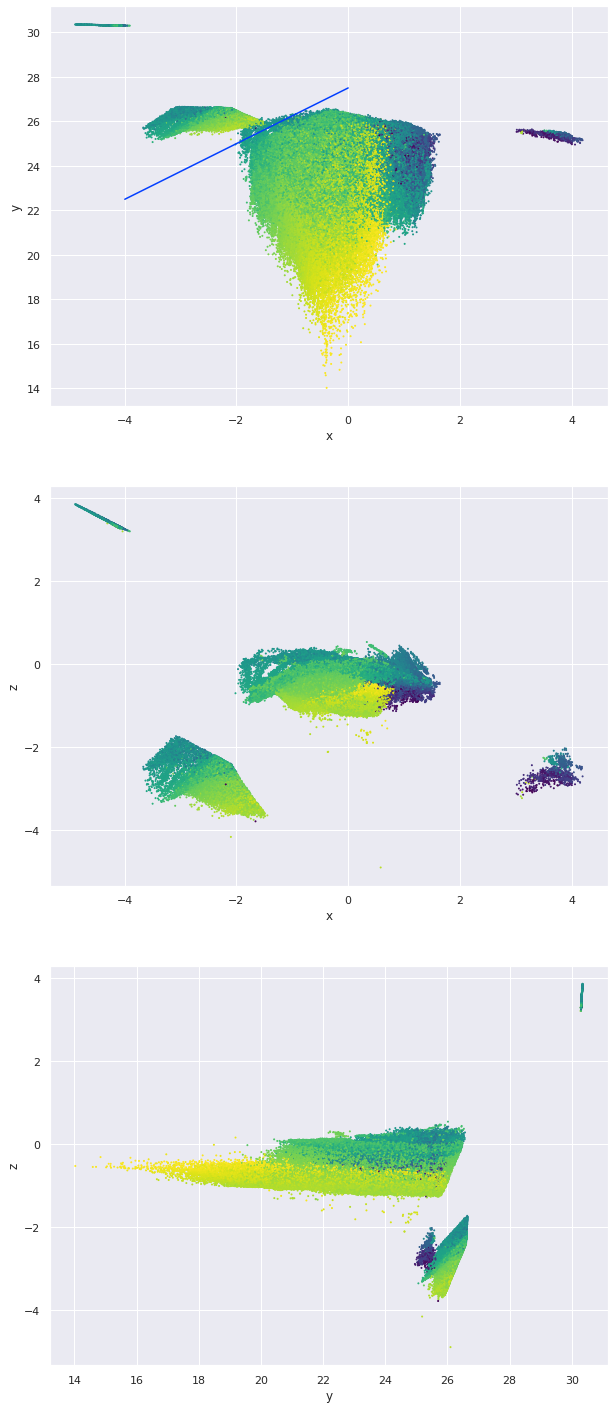

In [10]:
fig, ax = plt.subplots(3, 1, figsize=(10, 25))

# Plotting data itself.
im = ax[0].scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=z_cut, cmap="viridis_r")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

# The dividing line, is a lot more obvious on the buzzard data set.
def reg(x):
    return (x) * 5/4 + 27.5
ax[0].plot([-4, 0], reg(np.asarray([-4, 0])))

ax[1].scatter(data_cut[:, 0], data_cut[:, 2], s=1, c=z_cut, cmap="viridis_r")
ax[1].set_xlabel("x")
ax[1].set_ylabel("z")

ax[2].scatter(data_cut[:, 1], data_cut[:, 2], s=1, c=z_cut, cmap="viridis_r")
ax[2].set_xlabel("y")
ax[2].set_ylabel("z")

plt.show()

And here finally I plot the first plot from above but instead of using redshift I use bin assignment. As you can somewhat see, there is a rough correlation between just this 2d space and "true" redshift binning. And here was my question: can we find this binning (or a better one) using clustering methods?

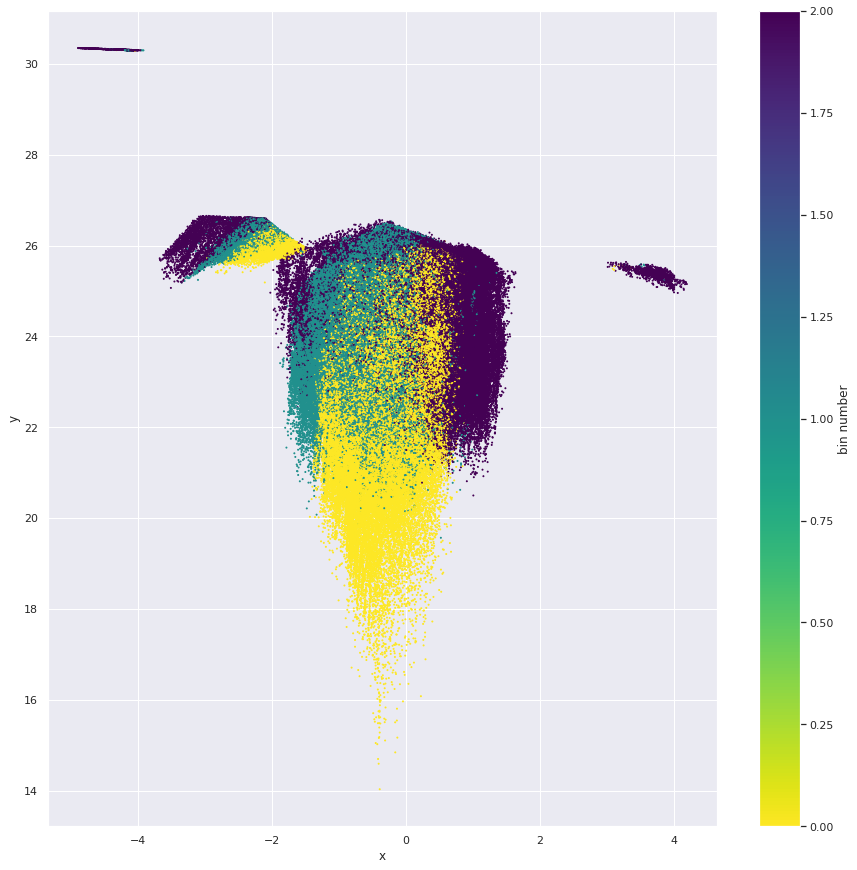

In [11]:
# Find the edges that split the redshifts into bins of
# equal number counts in each
# Here for demonstration purpose I do 3 bins
p = np.linspace(0, 100, 4)
z_edges = np.percentile(z_cut, p)
training_bin = np.zeros_like(data_cut[:, 0])

# Now find all the objects in each of these bins
for i in range(3):
    z_low = z_edges[i]
    z_high = z_edges[i + 1]
    training_bin[(z_cut > z_low) & (z_cut <= z_high)] = i
        
fig, ax = plt.subplots(figsize=(15, 15))

# Plotting data itself.
plt.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=training_bin, cmap="viridis_r")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar().set_label("bin number")

### K-Means as a Gradient Descent Problem

In order to solve a clustering problem, we need a clustering algorithm.

The most well known solution (but not necessarily the fastest) to solving the K-means clustering problem is Lloyd's algorithm, which is derived by transforming k-means clustering into an expectation-maximization-like process. However, it can also be solved as a gradient descent problem. My understanding comes pretty directly from [**Convergence Properties of K-Means Algorithms**](http://www.iro.umontreal.ca/~lisa/pointeurs/kmeans-nips7.pdf) by *Léon Bottou and Yoshou Bengio*.

Generally, K-means aims to minimize the distance between points and the cluster centers. We can define this as quantization error
\begin{equation}
E(w) = \sum_{i}{\frac{1}{2} \min_k{(x_i-w_k)^2}}
\end{equation}

The "weights" to update are the cluster centroids. The weight update rule $\Delta w =  -\alpha \frac{\partial E(w)}{\partial w}$ where $\alpha$ is the learning rate. Do a little math (I encourage you to read the paper for a more complete overview) and:

\begin{equation}
\Delta w_k = \sum_{i}{\alpha (x_i - w_k)}
\end{equation}

where $w_k$ is the centroid closest to the point $x_i$.

### Optimizing Alternative Metrics
From this we can alternatively derive weight updates that move the centroids in order to optimize any arbitrary metric. We can define now our "error" function as 

\begin{equation}
E(w) = f(\vec{x}, \vec{w})
\end{equation}

or in other words, as a function of the points $\vec{x}$ and the centroids $\vec{w}$. Here I use the vector arrow to donate matrices, as $\vec{x}$ and $\vec{w}$ are more accurately described as vectors of (in my case) $3$-dimensional points. In optimizing the tomography challenge this function is a little difficult to write down mathematically, but the function finds the distance to all the centroids, runs a softmax over it to turn it into a probability distribution, then passes it to the metric, either the SNR or the FOM. If we define our metric function as $M$ then this is approximately:

\begin{equation}
E(w) = M(\vec{\sigma})
\end{equation}

where $\vec{\sigma}$ is the vector matrix of softmax distances, defined such that the value at position $i, k$ is:

\begin{equation}
\sigma_{i,k} = \frac{\exp{(x_i - w_k)^2}}{\sum_{k}^{n_{bins}}{\exp{(x_i - w_k)^2}}}
\end{equation}

As before, $w_k$ is a centroid, and $x_i$ is a point in the dataset. Once we have this function defined we can do the same as before, and find the weight update:

\begin{equation}
\Delta w = -\alpha \frac{\partial E(w)}{\partial w}
\end{equation}

At that point the key is to pick the right $\alpha$ and away we go!

Or at least so we hope. As we'll see below, this method is extremely hyperparameter instable. Changing a single starting centroid can lead to drastically different results. We have methods to deal with that though.

In [12]:
@jax.jit
def softmax(x, beta=1):
    return jnp.exp(beta * x) / jnp.sum(jnp.exp(beta * x), axis=0)

@jax.jit
def dist(points, centroids, beta=1):
    # Finds the distance between the points and the centroids
    dist = []
    for center in centroids:
        shift = points - center
        dist.append(jnp.linalg.norm(shift, axis=1))

    # Converting to numpy array so we can use boolean indexing
    dist = jnp.asarray(dist)
    
    # Which category these would be assigned to based on their distances
    # soft min, don't have to one_hot then and the gradient should work.
    return softmax(-dist, beta).T 

@jax.jit
def dist_snr(points, centroids, z, beta=1):
    cat = dist(points, centroids, beta)
    return -compute_snr_score(cat, z, binned_nz=True)
    
@jax.jit
def dist_fom(points, centroids, z, beta=1):
    cat = dist(points, centroids, beta)
    return -compute_fom(cat, z, binned_nz=True)

@jax.jit
def dist_fom_detf(points, centroids, z, beta=1):
    cat = dist(points, centroids, beta)
    return -compute_fom(cat, z, inds=[5, 6], binned_nz=True)

Below is the method that actually implements the gradient descent. Let's briefly discuss an additional improvement I was able to make after the initial implementation. A softmax function's "steepness" can be controlled with a $\beta$ parameter. A higher $\beta$ brings the softmax closer to argmax, but can lead to overflow problems in gradient calculations. In theory (and in practice, it turns out) we can first optimize this $\beta$ before trying to optimize centroid positions. This works because in order to find the minimum of a function $f(\vec{x}, y)$  we can first minimize over the single variable $y$ before optimizing over $\vec{x}$. We could do the entire thing this way, optimizing each weight variable individually but that's pretty inefficient when it makes more sense to optimze centroid $(x, y, z)$ at the same time.

A quick and easy improvement that helps stabilize the training is to "anneal" the learning rate over time. In this scheme I use an exponential annealing, where the learning rate of each epoch is $0.9$ times the learning rate of the previous epoch.  

I additionally implemented a "range test," which steps through various learning rates from the start position, recording the metric value at each learning rate. Then we pick a learning rate near where the metric changes most rapidly in the positive direction per learning rate, i.e. the highest positive slope on the metric vs learning rate graph. In order to speed training to a good minimum I also discovered that using the best found metric value during the range test as a starting position for the training itself serves to not only speed training but in many cases takes us to a better maximum in parameter space. This is nearly equivalent to training with a "one-cycle" policy, where the learning rate is slowly (usually linearly) increased to a set value, then decreased back down. This works wonders for our problem. 

In [13]:
def range_test(points, redshift, beta, centroids, impl="fom", num=50, ind=1, verbose=False, high=-1):
    # The function we're optimizing, can't use string inputs in functions 
    # we're differentiating, hence this.
    if impl == "fom":
        d2 = dist_fom
    elif impl == "fom_detf":
        d2 = dist_fom_detf
    else:
        d2 = dist_snr
    
    val_hist = []
    improve_hist = []
    if ind == 3:
        to_improve = np.copy(beta)
    else:
        to_improve = np.copy(centroids)

    i = 0
    # We want to do this once first so the initial point is, well the starting SNR/FOM
    if ind == 3:
        val, grads = jax.value_and_grad(d2, ind)(points, centroids, redshift, to_improve)
    else:
        val, grads = jax.value_and_grad(d2, ind)(points, to_improve, redshift, beta)
    val_hist.append(-val)
    
    # More points will get you more accurate results but will take longer
    lr_arr = np.logspace(-6, high, num)
    for cur_lr in lr_arr:
        if verbose: print(f"Epoch {i+1}, LR {cur_lr}")
        i += 1
        if ind == 3:
            val, grads = jax.value_and_grad(d2, ind)(points, centroids, redshift, to_improve)
        else:
            val, grads = jax.value_and_grad(d2, ind)(points, to_improve, redshift, beta)

        if verbose: print(f"{impl.upper()}:", -val)
        # This is where the actual gradient descent is performed, and
        # the value is saved to find the optimal lr
        val_hist.append(-val)
        to_improve += -(grads) * cur_lr
        improve_hist.append(to_improve)

    # One liner that calculates the slopes between consecutive points.
    # Roll moves it back one so roll - original is equal to the difference
    # between a point and the next one in the array.
    slope = ((np.roll(val_hist[1:], -1) - val_hist[1:]) / (np.log10(np.roll(lr_arr, -1)) - np.log10(lr_arr)))[:-1]
    
    # The halfway point between each point, the "x" of the slope.
    x_slope = ((np.roll(lr_arr, -1) + lr_arr) / 2)[:-1]
    
    # For calculating the best value we achieved during this run.
    val_hist = np.asarray(val_hist)[1:]
    improve_hist = np.asarray(improve_hist)
    
    # "Best" learning rate is where the slope is the highest positive value
    # i.e. where the metric increases the most per learning rate step.
    print(f"Best {impl.upper()} achieved in range test: {np.nanmax(val_hist)}")
#     plt.plot(lr_arr, val_hist)
    return (x_slope[np.nanargmax(slope[1:])], improve_hist[np.argmax(val_hist)])

As you increase the number of bins, the method also becomes incredibly sensitive to starting conditions. There are various different starting points I tried, including but not limited to: random starts, the first $N$ points in the dataset, the last $N$ points in the dataset, the centroids generated by "true binning" and circularly distributed starting points. The latter is what I ended up discovering worked the best, by starting with centroids circularly centered in x and y around the center of the dataset, with radius 0.25. In the z direction I simply centered them.

In [14]:
def fit_centroids(points, redshift, num_centroids=3, num_epochs=10, impl="snr"):
#     ind = gen.randint(0, len(points), num_centroids)
#     ind = -(np.arange(0, num_centroids) + 1)
#     # Must shift by a little so we don't get nan gradients due to 0 distances
#     centroids = points[ind].astype("float32") + (np.ones_like(points[0]) / 100)
    
    cent = np.mean(points, axis=0)
    rad_diff = 2 * np.pi / num_centroids
    l = []
    for i in range(num_centroids):
        p = 0.25 * np.asarray([np.cos(i * rad_diff), np.sin(i * rad_diff), 0])
        l.append(p + cent)
    
    centroids = np.asarray(l)

    # Starting points
#     centroids = get_equality_centroids(points, redshift, num_centroids)
    beta = np.ones(1)

    # The function we're optimizing, can't use string inputs in functions 
    # we're differentiating, hence this.
    d2 = dist_fom if impl == "fom" else dist_snr
    
    # Index of the thing we're improving for taking derivative
    # And the thing we're improving.
    def loop_and_improve(val, ind, num_epochs, lr=0, verbose=False):
        to_improve = np.copy(val)
        snr_history = []
        
        # Terminate at the number of epochs or if the change 
        # in snr is too small to be meaningful. We also force 
        # a minimum of 2 epochs.
        i = 0
        delta_val = 1
        cur_lr = lr
        while (i < num_epochs and abs(delta_val) > 0.50) or i < 2:
            try:
                if verbose: print(f"Epoch {i + 1}")
                if ind == 3:
                    val, grads = jax.value_and_grad(d2, ind)(points, centroids, redshift, to_improve)
                else:
                    val, grads = jax.value_and_grad(d2, ind)(points, to_improve, redshift, beta)
                
                if verbose: print(f"{impl.upper()}:", -val)
                snr_history.append(-val)

                # Learning rate annealing
                cur_lr *= 0.9
                to_improve += -(grads) * cur_lr
                i += 1
                if verbose and len(snr_history) > 1:
                    delta_val = -val - snr_history[-2]
                    print(f"Delta {impl.upper()}: {delta_val}")
            except UnexpectedTracerError:
                # I swear this isn't my fault.
                if verbose: print("Tracer Error, retrying epoch")
                continue
                
        return (to_improve, snr_history)

    print("Beta loop. Finding optimal lr.")
    num_points = 50
    beta_lr, _ = range_test(data_cut, z_cut, beta, centroids, impl, num=num_points, ind=3)
    print(f"\nOptimal Beta lr: {beta_lr}")
    
    beta, _ = loop_and_improve(beta, 3, num_epochs, lr=beta_lr, verbose=True)
    print(f"Final beta: {beta}")

    # Once we have improved beta we can continue on to do the centroids themselves.
    print("Centroids loop. Finding optimal lr.")
    top = -2 if impl != "fom_detf" else -1 # I wonder why the DETF has smaller gradients.
    centroid_lr, centroids = range_test(data_cut, z_cut, beta, centroids, impl, num=num_points, high=top)
    print(f"\nOptimal centroids lr: {centroid_lr}")

    # It's the eleventh hour and I don't quit have the time at the moment
    # to prove rigorously that this is a good choice for lr but it is.
    # I think that we actually want the lr to be on the order of 10^-3
    # And in general this serves to do that, but without further testing
    # I can't prove that's the case (yet)
    if num_centroids < 8:
        best_lr = centroid_lr / 10
    else:
        best_lr = centroid_lr
        
    centroids, loss = loop_and_improve(centroids, 1, num_epochs, lr=best_lr, verbose=True)
    
    # In case the final tracer escapes just run it again. 
    # Janky, but what part of Jax isn't?
    try:
        print(f"Final {impl.upper()}:", -d2(points, centroids, redshift, beta))
    except UnexpectedTracerError:
        print(f"Final {impl.upper()}:", -d2(points, centroids, redshift, beta))
        
    print(f"Final beta: {beta}")
    plt.plot(np.arange(0, len(loss)) + 1, loss, label=num_centroids)
    return centroids

@jax.jit
def classify(points, centroids):
    # Finds the distance between the points and the centroids
    dist = []
    for center in centroids:
        shift = points - center
        dist.append(jnp.linalg.norm(shift, axis=1))

    # Converting to numpy array so we can use boolean indexing
    dist = jnp.asarray(dist)

#     Which category these would be assigned to based on their distances
    return jnp.argmin(dist, axis=0)

Beta loop. Finding optimal lr.


/global/homes/d/dylang/.conda/envs/tomo-jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Best FOM achieved in range test: 1017.7160279979801

Optimal Beta lr: 0.0026385017565335907
Epoch 1
FOM: 118.58073113017352
Epoch 2
FOM: 184.95808154764194
Delta FOM: 66.37735041746842
Epoch 3
FOM: 258.9040993688015
Delta FOM: 73.94601782115956
Epoch 4
FOM: 328.8116597108853
Delta FOM: 69.9075603420838
Epoch 5
FOM: 388.7890407482044
Delta FOM: 59.977381037319105
Epoch 6
FOM: 438.0817893120261
Delta FOM: 49.292748563821704
Epoch 7
FOM: 478.0840489965048
Delta FOM: 40.0022596844787
Epoch 8
FOM: 510.59347863617205
Delta FOM: 32.509429639667246
Epoch 9
FOM: 537.2028067669856
Delta FOM: 26.609328130813594
Epoch 10
FOM: 559.1790250376829
Delta FOM: 21.976218270697245
Epoch 11
FOM: 577.4948603228116
Delta FOM: 18.315835285128742
Epoch 12
FOM: 592.8911007221564
Delta FOM: 15.39624039934472
Epoch 13
FOM: 605.933898919963
Delta FOM: 13.042798197806633
Epoch 14
FOM: 617.0596643344129
Delta FOM: 11.125765414449916
Epoch 15
FOM: 626.60837222337
Delta FOM: 9.548707888957097
Epoch 16
FOM: 634.8478367

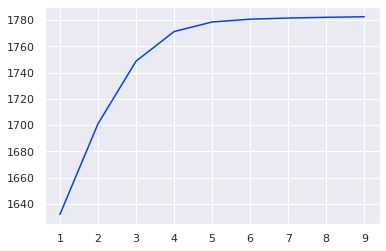

In [15]:
t0 = time.perf_counter()
centers = fit_centroids(data_cut, z_cut, num_centroids=3, num_epochs=70, impl="fom")
duration = time.perf_counter() - t0
print(f"Trained in {duration} seconds")

Now that we've trained, let's plot a two dimensional plot like above with bin assignments. From there
I categorize all points to make a histogram and then run it on the validation set. As we can see, thanks to the magic of jax and JIT compilation, we can categorize the whole validation set in just over half a second! 

Text(0, 0.5, 'y')

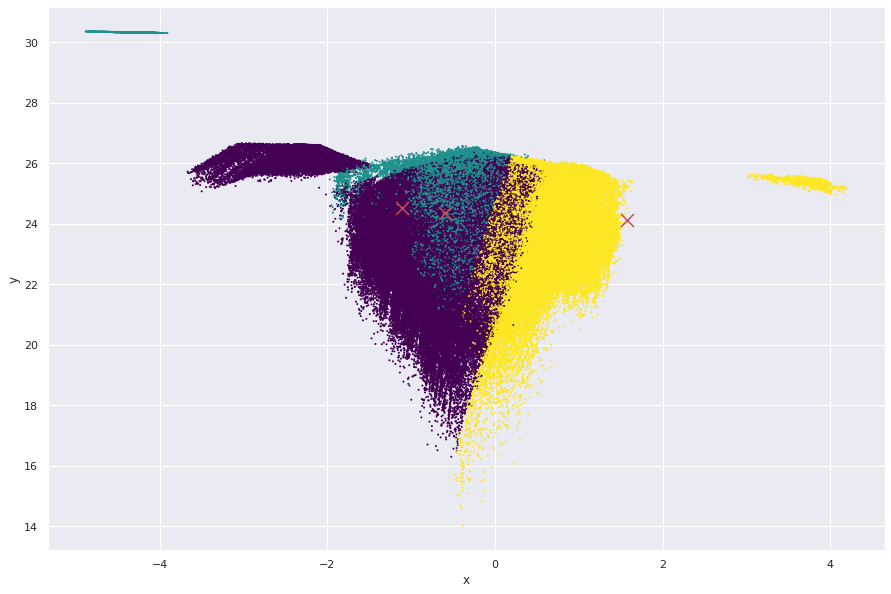

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))

y_train = classify(data_cut, centers)

# Plotting data itself.
ax.scatter(data_cut[:, 0], data_cut[:, 1], s=1, c=y_train, cmap="viridis_r")
ax.scatter(centers[:, 0], centers[:, 1], marker='x', s=169, linewidths=3,
            color='r', zorder=10)
ax.set_xlabel("x")
ax.set_ylabel("y")

Classified all points in 0.19101711711846292 seconds


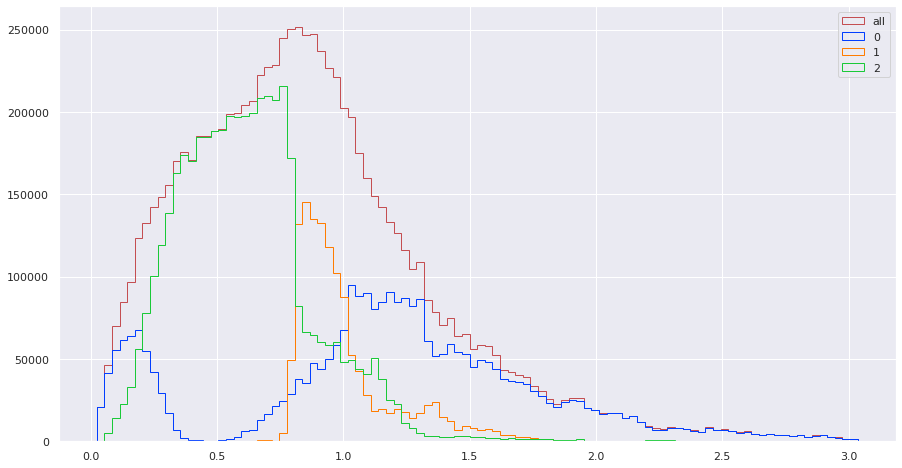

In [17]:
# Predict the categories of the full and uncut dataset and then make a histogram
# Once we have the individual group histograms I additionally plot a
# histogram of the entire dataset to verify it adds up.
t0 = time.perf_counter()
y_train = classify(data_reduced, centers)

print(f"Classified all points in {time.perf_counter() - t0} seconds")

fig, ax = plt.subplots(figsize=(15, 8))
_, bins, _ = plt.hist(z_train, bins=100, histtype="step", color="r", label="all")

for i in range(0, int(y_train.max()) + 1):
    plt.hist(z_train[y_train == i], bins=bins, histtype="step", label=i)
plt.legend()
plt.show()

In [18]:
x_valid = pd.DataFrame.from_dict(tc.load_data(f"{d_loc}/validation.hdf5", "griz", colors=True))
z_valid = tc.load_redshift(f"{d_loc}/validation.hdf5")

data_valid = x_valid[["r", "gr", "ri", "rz"]].to_numpy()
data_valid_r = data_valid @ reducer

Classified all points in 0.5359806269407272 seconds


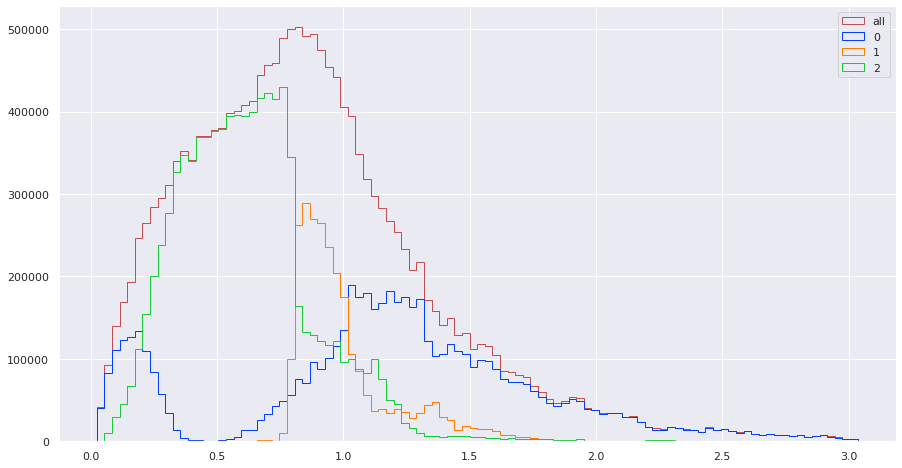

In [19]:
# Predict the categories of the full and uncut dataset and then make a histogram
# Once we have the individual group histograms I additionally plot a
# histogram of the entire dataset to verify it adds up.
t0 = time.perf_counter()
valid_cond = data_valid_r[:, 1] < reg(data_valid_r[:, 0])
# y_valid = total_classify(data_valid_r, lower_centers, upper_aligned, valid_cond)

y_valid = classify(data_valid_r, centers)

print(f"Classified all points in {time.perf_counter() - t0} seconds")

fig, ax = plt.subplots(figsize=(15, 8))
_, bins, _ = plt.hist(z_valid, bins=100, histtype="step", color="r", label="all")

for i in range(0, int(y_valid.max()) + 1):
    plt.hist(z_valid[y_valid == i], bins=bins, histtype="step", label=i)
plt.legend()
plt.show()

In [20]:
# Compute those scores.
print(f"Computing the scores for {y_valid.max() + 1} bins.")
t0 = time.perf_counter()
scores = tc.jc_compute_scores(y_valid, z_valid)
duration = time.perf_counter() - t0
print(f"{scores} in {duration} seconds")

Computing the scores for 3 bins.
{'SNR_ww': 338.3129783782393, 'FOM_ww': 12.421964455516054, 'FOM_DETF_ww': 0.36897862217195004, 'SNR_gg': 1006.7613562416634, 'FOM_gg': 319.0697116818443, 'FOM_DETF_gg': 3.6690321992969657, 'SNR_3x2': 1017.3742124612335, 'FOM_3x2': 2093.336256675548, 'FOM_DETF_3x2': 49.017569258330624} in 397.08087350497954 seconds


## Improvement with number of bins

Originally the algorithm was extremely sensitive, and anything above 4 bins showed absolutely no improvement. By annealing the learning rate as described above but also by adding a range test, I was able to mitigate if not completely solve this problem. 

The justification for this is with more bins, bin assignment is a lot more sensitive to really small changes in bin positions, as a single centroid moving can change points along on average $~3$ boundaries (with some back of napkin math). In this regime a lower learning rate for more precise changes is better as you increase the number of bins. The method is also sensitive to number of bins since each additional bin increases the dimensionality of the parameter space by 3. 

Including this improvement as well as the range test outlined above removes the plateauing that was initially present in $>4$ bins in FOM training but there may be another plateau at a higher value that is lurking underneath.

Classifying 4 bins.
Beta loop. Finding optimal lr.
Best FOM_DETF achieved in range test: 14.464996948821943

Optimal Beta lr: 0.07078297568090838
Epoch 1
FOM_DETF: 673.6310601173442
Epoch 2
FOM_DETF: 679.3676951449519
Delta FOM_DETF: 5.73663502760769
Epoch 3
FOM_DETF: 693.0382858047499
Delta FOM_DETF: 13.670590659797995
Epoch 4
FOM_DETF: 718.2391987575728
Delta FOM_DETF: 25.200912952822932
Epoch 5
FOM_DETF: 748.9891724066982
Delta FOM_DETF: 30.749973649125423
Epoch 6
FOM_DETF: 774.5326576335403
Delta FOM_DETF: 25.543485226842108
Epoch 7
FOM_DETF: 792.2980982858757
Delta FOM_DETF: 17.765440652335315
Epoch 8
FOM_DETF: 804.4166897239354
Delta FOM_DETF: 12.118591438059752
Epoch 9
FOM_DETF: 812.9472735564036
Delta FOM_DETF: 8.53058383246821
Epoch 10
FOM_DETF: 819.1828886894298
Delta FOM_DETF: 6.235615133026158
Epoch 11
FOM_DETF: 823.8948697176894
Delta FOM_DETF: 4.711981028259629
Epoch 12
FOM_DETF: 827.5543272144105
Delta FOM_DETF: 3.6594574967210747
Epoch 13
FOM_DETF: 830.4603905672163
Del

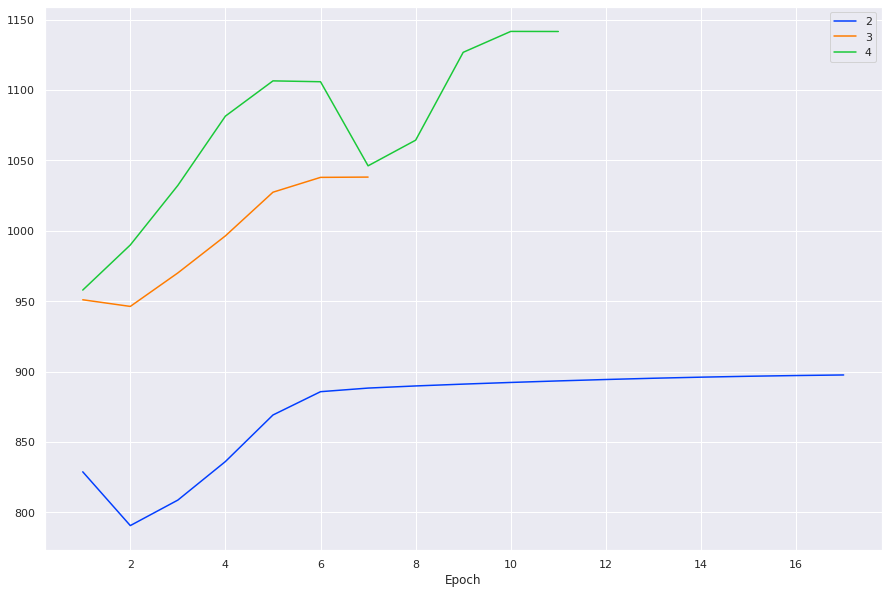

In [21]:
# Compute those scores.
score_hist_jc = []

fig, ax = plt.subplots(figsize=(15, 10))

z_cut = z_train[cut]
for j in range(2, 5):
    clear_output(wait=True)
    print(f"Classifying {j} bins.")
    
    t0 = time.perf_counter()
    centers = fit_centroids(data_cut, z_cut, num_centroids=j, num_epochs=70, impl="fom_detf")
    duration = time.perf_counter() - t0
    print(f"Trained in {duration} seconds")

    y_valid = classify(data_valid_r, centers)
    
    print(f"Computing scores for {j} bins.")
    try:
        score_hist_jc.append(tc.jc_compute_scores(y_valid, z_valid))
    except UnexpectedTracerError:
        score_hist_jc.append(tc.jc_compute_scores(y_valid, z_valid))
plt.legend()
plt.xlabel("Epoch")
plt.show()

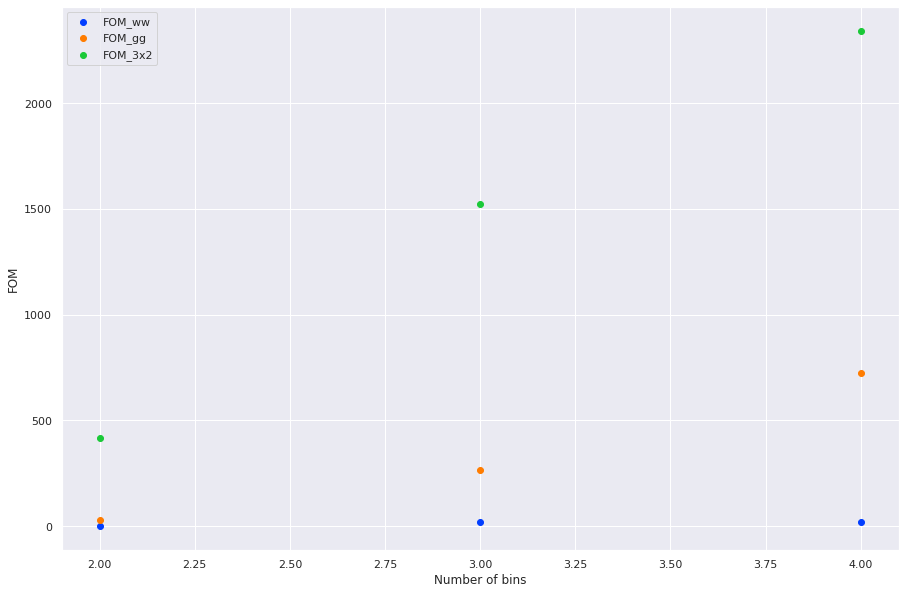

In [22]:
metric = "FOM"
x_hist = np.arange(2, len(score_hist_jc) + 2)
snr_gg = np.asarray([x[f"{metric}_gg"] for x in score_hist_jc])
snr_ww = np.asarray([x[f"{metric}_ww"] for x in score_hist_jc])
snr_32 = np.asarray([x[f"{metric}_3x2"] for x in score_hist_jc])

fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(x_hist, snr_ww[x_hist - 2], label=f"{metric}_ww")
plt.scatter(x_hist, snr_gg[x_hist - 2], label=f"{metric}_gg")
plt.scatter(x_hist, snr_32[x_hist - 2], label=f"{metric}_3x2")
plt.xlabel("Number of bins")
plt.ylabel(metric)
plt.legend()
plt.savefig("hist_detf.png")

If you got to this cell and think I really like f-strings, you're right.